<h3>LLM Architecture</h3>

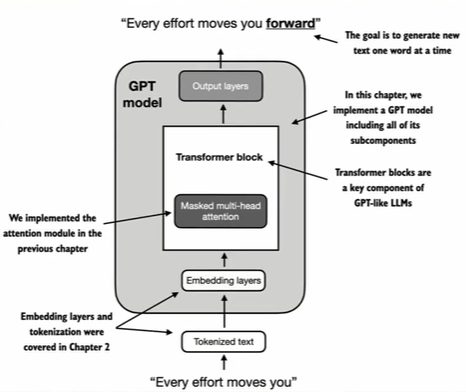

<h3>Transformer architecture</h3>

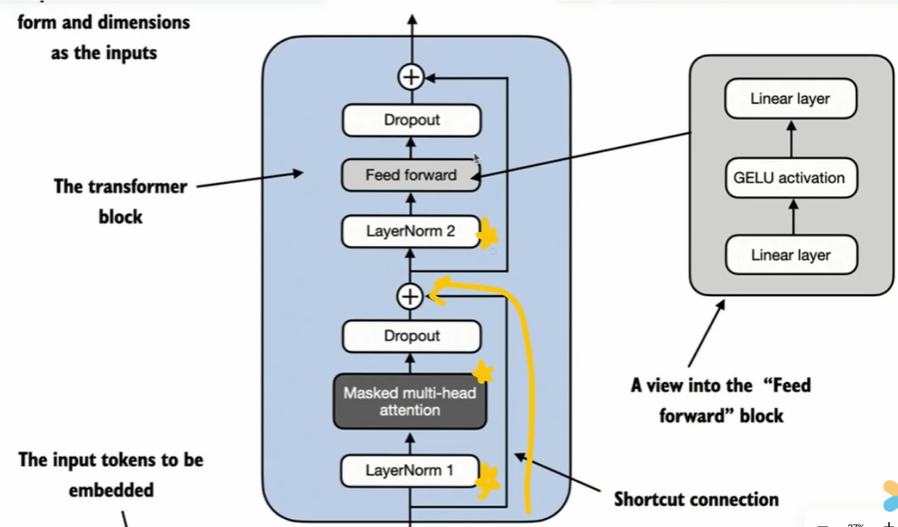

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

<h1>GPT ARCHITECTURE PART 1: DUMMY GPT MODEL CLASS (Bird's eye view)</h1>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Step 1: Use a placeholder for TransformerBlock<br>
    Step 2: Use a placeholder for LayerNorm
</div>

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    <ul>
        <li>The DummyGPTModel class in this code defines a simplified version of a GPT-like model using PyTorch's neural network module (nn.Module).</li>
        <li>The model architecture in the DummyGPTModel class consists of token and positional embeddings, dropout, a series of transformer blocks (DummyTransformerBlock), a final layer normalization (DummyLayerNorm), and a linear output layer (out_head).</li>
        <li>The configuration is passed in via a Python dictionary, for instance, the GPT_CONFIG_124M dictionary we created earlier.</li>
        <li>The forward method describes the data flow through the model: it computes token and positional embeddings for the input indices, applies dropout, processes the data through the transformer blocks, applies normalization, and finally produces logits with the linear output layer.</li>
        <li>The code above is already functional, as we will see later in this section after we prepare the input data.</li>
        <li>However, for now, note in the code above that we have used placeholders (DummyLayerNorm and DummyTransformerBlock) for the transformer block and layer normalization, which we will develop in later sections</li>
    </ul>
</div>

<div style="background-color: #B8B8FF; color: black; padding: 10px">
    Next, we will prepare the input data and initialize a new GPT model to illustrate its usage.
</div>

<h4>STEP 1: TOKENIZATION</h4>

In [3]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


<h4>STEP 2: CREATE AN INSTANCE OF DUMMYGPTMODEL</h4>

In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


<div style="background-color: #B8B8FF; color: black; padding: 10px">
    <ul>
        <li>The output tensor has two rows corresponding to the two text samples. Each text sample consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer's vocabulary.</li>
        <li>The embedding has 50,257 dimensions because each of these dimensions refers to a unique token in the vocabulary. At the end of this chapter, when we implement the postprocessing code, we will convert these 50,257-dimensional vectors back into token IDs, which we can then decode into words.</li>
        <li>Each cells of this 50,257-dimensional vector stores probabilities for each word from vocabulary and next word that is predicted will have highest probability in this 50,257-dimensional vector.</li>
    </ul>
</div>

<div style="background-color: #21CC77; color: black; padding: 10px;">
    Now that we have taken a top-down look at the GPT architecture and its in- and outputs, we will code the individual placeholders in the upcoming sections, starting with the real layer normalization class that will replace the DummyLayerNorm in the previous code.
</div>